In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
import numpy
import cv2
import sklearn
import torch
import sys
import os

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("TensorFlow Hub:", hub.__version__)
print("NumPy:", numpy.__version__)
print("OpenCV:", cv2.__version__)
print("scikit-learn:", sklearn.__version__)
print("PyTorch:", torch.__version__)
print("CUDA available (Torch):", torch.cuda.is_available())


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow: 2.18.0
Keras: 3.8.0
TensorFlow Hub: 0.16.1
NumPy: 2.0.2
OpenCV: 4.11.0
scikit-learn: 1.6.1
PyTorch: 2.6.0+cu124
CUDA available (Torch): True


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Check GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
def preprocess(img, label):
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

BATCH_SIZE=32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
# Load MobileNetV2 (from tf.keras.applications, not TFHub)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'  # Global average pooling at the end
)
base_model.trainable = False  # Freeze for feature extraction

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
from tensorflow import keras
from keras import layers

# Build Model
model= keras.Sequential([
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [12]:
# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
!nvidia-smi

Sun Jun 29 10:11:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             31W /   70W |    2168MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
# ✅ Train
history = model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8324 - loss: 0.4757 - val_accuracy: 0.8114 - val_loss: 0.5411
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.8468 - loss: 0.4428 - val_accuracy: 0.8136 - val_loss: 0.5458
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.8570 - loss: 0.4044 - val_accuracy: 0.8228 - val_loss: 0.5267
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 38ms/step - accuracy: 0.8672 - loss: 0.3717 - val_accuracy: 0.8015 - val_loss: 0.6060
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - accuracy: 0.8787 - loss: 0.3415 - val_accuracy: 0.8158 - val_loss: 0.5614


In [21]:
model.evaluate(train_ds)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.8849 - loss: 0.3207


[0.3025737404823303, 0.8921999931335449]

In [22]:
model.evaluate(test_ds)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8137 - loss: 0.5717


[0.5614220499992371, 0.8158000111579895]

In [24]:
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(test_ds)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]))


              precision    recall  f1-score   support

    airplane       0.83      0.88      0.85      1000
  automobile       0.85      0.94      0.89      1000
        bird       0.76      0.76      0.76      1000
         cat       0.73      0.62      0.67      1000
        deer       0.77      0.80      0.79      1000
         dog       0.76      0.77      0.76      1000
        frog       0.78      0.90      0.84      1000
       horse       0.84      0.82      0.83      1000
        ship       0.91      0.84      0.87      1000
       truck       0.93      0.84      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.81     10000
weighted avg       0.82      0.82      0.81     10000



<Axes: >

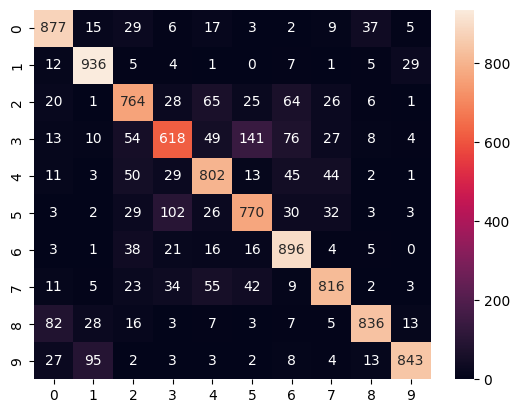

In [30]:
import seaborn as sns
cm= confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',)